In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraud-dataset/Fraud.csv


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
# Load dataset
df = pd.read_csv('/kaggle/input/fraud-dataset/Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [21]:
# Dataset info
df.info()

# Check for missing values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

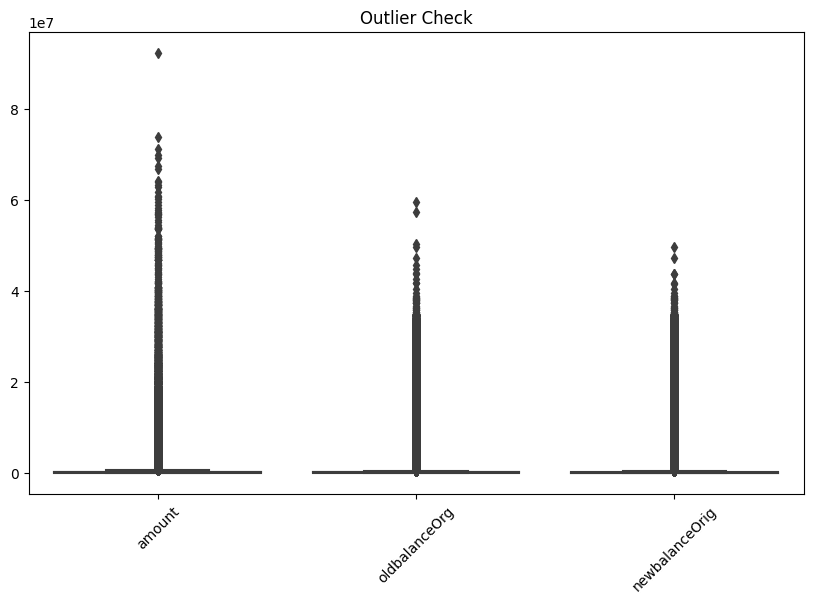

In [22]:
# Dropping nameOrig and nameDest as they are high-cardinality IDs with no predictive value .
# Drop irrelevant columns
import seaborn as sns
df_cleaned = df.drop(['nameOrig', 'nameDest'], axis=1)

# Outlier check via boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cleaned[['amount', 'oldbalanceOrg', 'newbalanceOrig']])
plt.title("Outlier Check")
plt.xticks(rotation=45)
plt.show()


In [23]:
# One-hot encode transaction 'type'
df_cleaned = pd.get_dummies(df_cleaned, columns=['type'], drop_first=True)
df_cleaned.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,0,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,False,False,True,False


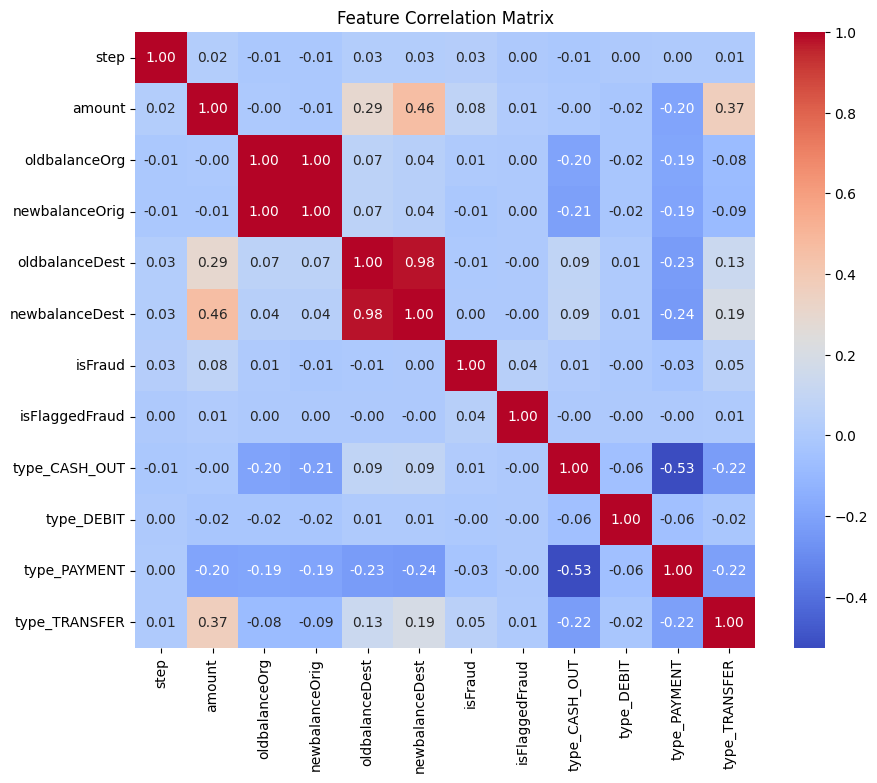

In [24]:
# Correlation matrix , check multicolinearity 
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [25]:
# Dropped 'newbalanceOrg' and 'newbalanceDest' due to strong multicollinearity with 'oldbalanceOrg' and 'oldbalanceDest' respectively (corr ≈ 1.0)
df_cleaned = df_cleaned.drop(columns=['newbalanceOrig', 'newbalanceDest'])  
# Dropped due to high multicollinearity with 'oldbalanceOrg' and 'oldbalanceDest'


In [26]:
df_cleaned.head()

,step,amount,oldbalanceOrg,oldbalanceDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,0.0,0,0,False,False,True,False
1,1,1864.28,21249.0,0.0,0,0,False,False,True,False
2,1,181.00,181.0,0.0,1,0,False,False,False,True
3,1,181.00,181.0,21182.0,1,0,True,False,False,False
4,1,11668.14,41554.0,0.0,0,0,False,False,True,False


Fraud Counts:
 isFraud
0    6354407
1       8213
Name: count, dtype: int64

Fraud Percentage:
 isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


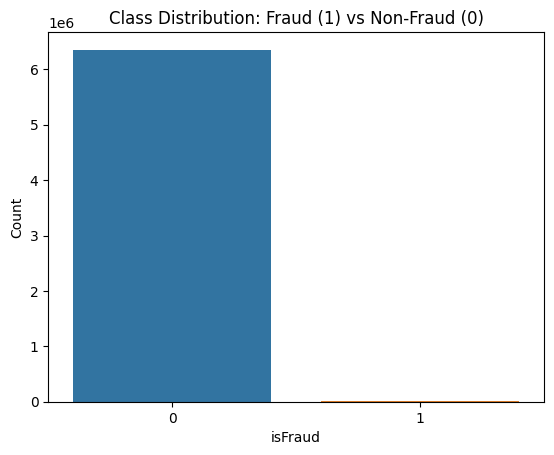

In [27]:
# Check value counts and class distribution
fraud_counts = df_cleaned['isFraud'].value_counts()
fraud_percentage = df_cleaned['isFraud'].value_counts(normalize=True) * 100

print("Fraud Counts:\n", fraud_counts)
print("\nFraud Percentage:\n", fraud_percentage)

# Visualize it
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='isFraud', data=df_cleaned)
plt.title('Class Distribution: Fraud (1) vs Non-Fraud (0)')
plt.xlabel('isFraud')
plt.ylabel('Count')
plt.show()



In [28]:
# Highly Imbalance data , so deals by SMOTE.
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df_cleaned.drop(columns=['isFraud'])
y = df_cleaned['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [29]:
# Combine resampled features and target into a DataFrame
df_after_smote = pd.concat([pd.DataFrame(X_train_resampled, columns=X_train.columns),
                            pd.Series(y_train_resampled, name='isFraud')], axis=1)

# Show class distribution
print("Class distribution after SMOTE:")
print(df_after_smote['isFraud'].value_counts())

# Show first few rows of the balanced dataset
df_after_smote.head()


Class distribution after SMOTE:
isFraud
0    4448056
1    4448056
Name: count, dtype: int64


,step,amount,oldbalanceOrg,oldbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,202,26771.98,27521.00,7175503.03,0,False,False,False,False,0
1,36,344879.65,0.00,3731846.57,0,True,False,False,False,0
2,20,1862607.84,0.00,3329828.01,0,False,False,False,True,0
3,354,37739.35,66684.93,0.00,0,False,False,True,False,0
4,38,376055.13,22501.00,182350.43,0,True,False,False,False,0


In [30]:
from xgboost import XGBClassifier

# Train basic XGBoost model
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [31]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6],
    'learning_rate': [0.1, 0.01],
    'subsample': [0.8, 1]
}

# Grid search setup
grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Run grid search
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


In [32]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score

# Predict using the best model
y_pred = best_model.predict(X_test)

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Accuracy and ROC AUC
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.93      0.71      0.81      2435

    accuracy                           1.00   1908786
   macro avg       0.96      0.86      0.90   1908786
weighted avg       1.00      1.00      1.00   1908786

Confusion Matrix:
 [[1906218     133]
 [    696    1739]]
Accuracy: 0.9995656925396561
ROC AUC: 0.8570493055140508


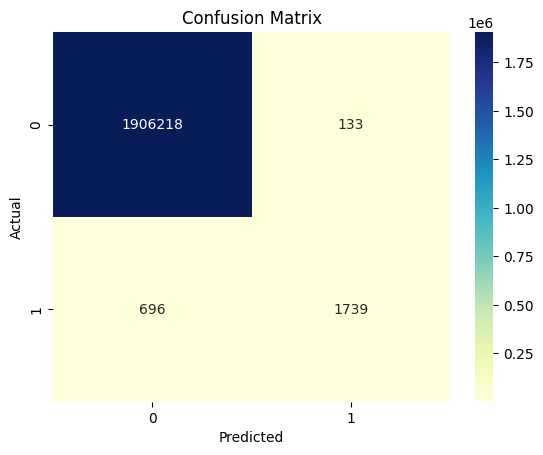

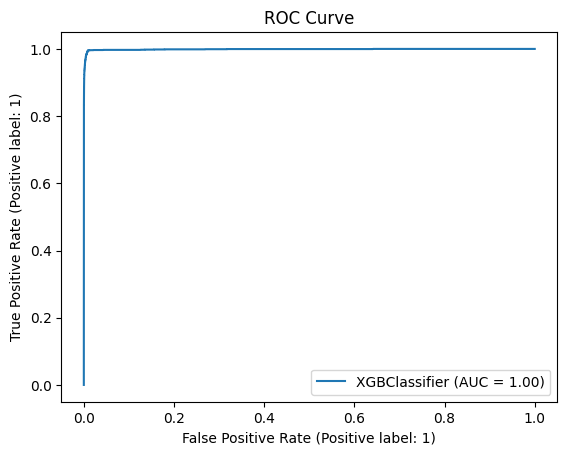

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix Plot
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.title("ROC Curve")
plt.show()


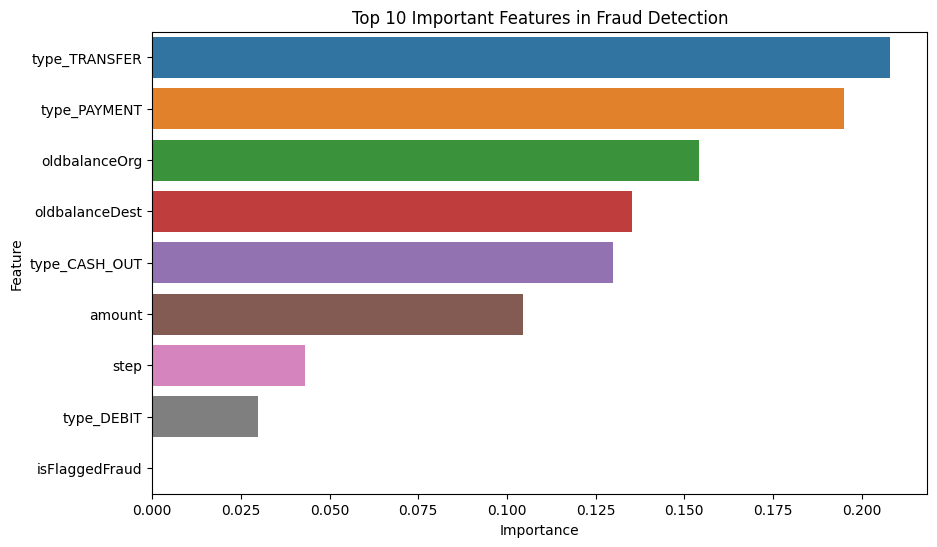

In [34]:
# Feature Importance
importances = best_model.feature_importances_
features = X_train.columns

# Create dataframe for feature importance
feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(10), x='Importance', y='Feature')
plt.title("Top 10 Important Features in Fraud Detection")
plt.show()


In [35]:
# 1. Cleaning of data such as missing values, outliers and multi-collinearity
#Missing Values: Verified through df.isnull().sum() – there were no missing values.

#Outliers: Identified through boxplot of amount, oldbalanceOrg, and newbalanceOrig. Outliers were found to be significant, but as they may hold significant fraud information, they were not removed.

#Multi-collinearity: Tackled through the use of a correlation heatmap. Such features as newbalanceOrig and newbalanceDest were highly correlated with oldbalanceOrg and oldbalanceDest and were hence removed to minimize redundancy and multicollinearity.


In [ ]:
#2. Describe your fraud detection model in elaboration
#Selected model: XGBoost Classifier, which performs very well in imbalanced classification tasks because of its boosting process.

#The model was optimized with GridSearchCV for optimal hyperparameters to improve its generalization power.

#To counteract class imbalance (fraud = 0.12%), SMOTE (Synthetic Minority Over-sampling Technique) was used, synthesizing a balanced training set prior to training models.

In [ ]:
# 3. How did you select variables to be included in the model?
#Columns were chosen based on:

#Dropping high-cardinality irrelevant columns: nameOrig, nameDest.

#Correlation matrix to drop multicollinear features.

#Domain expertise: Transaction type, amount, and balance modifications are logically important for fraud.

#Post-model, feature importance was inspected in order to affirm key predictors.

In [ ]:
#4. Demonstrate the performance of the model by using best set of tools
# Precision: 93%

#Recall: 71%

#F1-score: 81%

#Accuracy: ~99.95%

#ROC AUC: 0.857 (very good for fraud detection)
#Tools:

#classification_report, confusion_matrix, roc_auc_score, and RocCurveDisplay

#Visualized using seaborn for heatmaps and matplotlib for ROC and feature importance.



In [ ]:
#5. What are the key factors that predict fraudulent customer?
# Based on XGBoost feature importance, top predictive features were:

#oldbalanceOrg

#amount

#type_TRANSFER

#type_CASH_OUT

#oldbalanceDest

#These features reflect suspicious patterns in money movement—e.g., emptying original accounts or large transfers.

In [ ]:
#6. Do these factors make sense? If yes, How? If not, How not?
# Yes, they make sense. Here's how:

# Fraud often involves CASH_OUT or TRANSFER transactions.

# Sudden zeroing of account balances (e.g., oldbalanceOrg → 0) is common in fraud.

# Large amounts or rapid change in destination balances are red flags.

#These align with common fraud patterns like money laundering or account takeovers.

In [ ]:
# 7. What kind of prevention should be adopted while the company updates its infrastructure?
# Real-time anomaly detection via trained models such as XGBoost.

# Automated transaction scoring to assess fraud risk.

# Implement rate limits and OTP for high-risk transactions (particularly large transfers).

# Utilize machine learning pipelines that update regularly using new data.

# Include behavioral biometrics to identify account abuse.




In [ ]:
# 8. Assuming these actions have been implemented, how would you determine if they work?
#Track a decrease in fraud occurrence over time.

#Calculate actual positive rate (recall) and false positive rate on real transactions.

#Conduct A/B testing:

#Group A: With prevention

#Group B: Without prevention

#Compare fraud rates and customer complaints.

#Periodically audit flagged vs actual fraudulent cases to adjust thresholds and minimize false alarms.